In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from astropy.time import Time

from matplotlib.ticker import MultipleLocator

In [2]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.size'] = '25'
mpl.rcParams['xtick.labelsize'] = '20'
mpl.rcParams['ytick.labelsize'] = '20'

In [3]:
print('NumPy version: {}'.format(np.__version__))
print('pandas version: {}'.format(pd.__version__))
print('matplotlib version: {}'.format(mpl.__version__))

NumPy version: 1.19.2
pandas version: 1.1.3
matplotlib version: 3.3.2


In [4]:
#%matplotlib notebook

In [4]:
# SN metadata

z = 0.0307
t_max = 2458986.91
t_max_mjd = t_max - 2400000.5

In [5]:
def plot_box_spec(wave, flux): 
    flux_plot = np.repeat(flux, 2)
    wv_plot = wave.copy()
    wv_plot[:-1] += np.diff(wave)/2
    wv_plot = np.append(wave[0]-(wave[1]-wave[0])/2, 
                        np.append(np.repeat(wv_plot[0:-1], 2), 
                                  wave[-1]+(wave[-1]-wave[-2])/2))
    
    return wv_plot, flux_plot

In [6]:
spec_files = glob.glob('./ZTF20aayhacx*ascii')
spec_files.sort()

In [7]:
spec_files

['./ZTF20aayhacx_20200507_P60_v2.ascii',
 './ZTF20aayhacx_20200513_NOT_v4.ascii',
 './ZTF20aayhacx_20200521_P60_v2.ascii',
 './ZTF20aayhacx_20200528_P60_v2.ascii',
 './ZTF20aayhacx_20200529_Lick_3-m_v1.ascii',
 './ZTF20aayhacx_20200608_P60_v2.ascii',
 './ZTF20aayhacx_20200609_GNIRS.ascii',
 './ZTF20aayhacx_20200610_P200_v1.ascii',
 './ZTF20aayhacx_20200623_Keck1_v1.ascii',
 './ZTF20aayhacx_20200915_Keck1_v2.ascii',
 './ZTF20aayhacx_20201020_Keck1_v1.ascii']

Try the observation date.


/Users/chang/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Try the observation date.
Try the observation date.


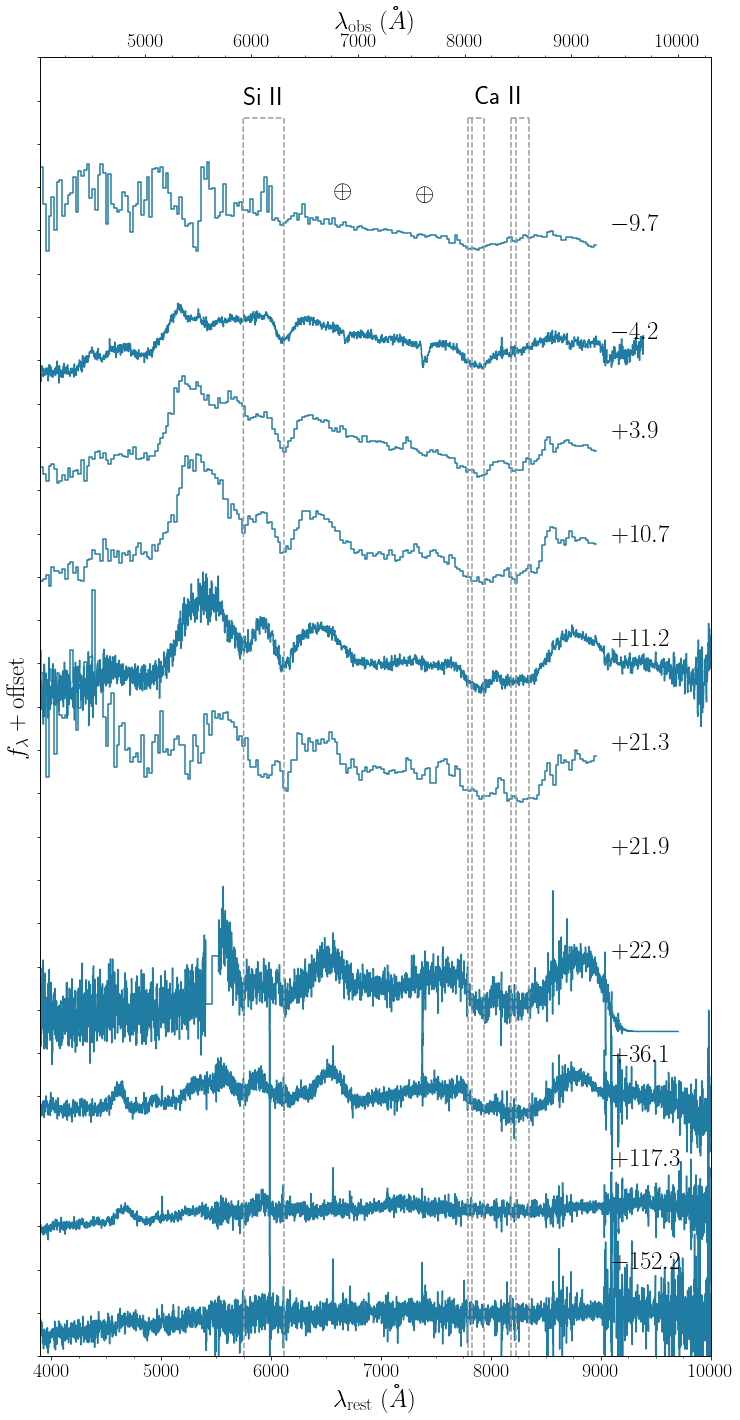

In [8]:
aam_colors = {
    'mustard': "#E29930",
    'blue': "#217CA3",
    'asphalt': "#32384D",
    'navy': "#444C5C",
    'punch': "#CE5A57",
    'ocean': "#78A5A3",
    'warm': "#E1B16A",
}

phase_list = []
mjd_list = []

fig, ax = plt.subplots(figsize=(10, 20))

for spec_num, spec in enumerate(spec_files):
    spec_df = pd.read_csv(spec,
                          comment='#',
                          delim_whitespace=True,
                          header=None)

    wv, fl = plot_box_spec(spec_df[0].values, spec_df[1].values)

    norm_flux = np.nanmedian(fl[np.where((wv > 7200) & (wv < 7400))])
    ax.plot(wv / (1 + z),
            fl / norm_flux - 2.5 * spec_num,
            color=aam_colors['blue'])

    with open(spec) as f:
        ll = f.readlines()
    # brute force
    mjd_found = False
    for l in ll:
        if 'MJD' in l:
            mjd_found = True
            if '=' in l and 'at start' in l:
                mjd_obs = float(l.split('=')[1].split("'")[1])
            elif '=' in l and '/' in l:
                mjd_obs = float(l.split('=')[1].split('/')[0])
            elif '=' in l:
                mjd_obs = float(l.split('=')[1])
            elif ':' in l:
                mjd_obs = float(l.split(':')[1])
            break
    if not mjd_found:
        print('Warning: MJD-obs not found in {}!'.format(spec))
        print('Try the observation date.')
        year = 2020
        pos_dat = spec.find(str(year))
        year_obs = spec[pos_dat:pos_dat+4]
        mon_obs = spec[pos_dat+4:pos_dat+6]
        date_obs = spec[pos_dat+6:pos_dat+8]
        mjd_obs = Time('{}-{}-{}'.format(year_obs, mon_obs, date_obs)).mjd
        

    phase = (mjd_obs - t_max_mjd) / (1 + z)
    phase_list.append(phase)
    mjd_list.append(mjd_obs)
    if mjd_obs < t_max_mjd:
        ax.text(9100, 1 - 2.5 * spec_num, r'$-{:.1f}$'.format(np.abs(phase)))
    else:
        ax.text(9100, 1 - 2.4 * spec_num, r'$+{:.1f}$'.format(np.abs(phase)))

ax.set_xlim(3900, 10000)
ax.set_ylim(-25., 5)
ax.set_yticklabels([])
ax.set_ylabel(r'$f_\lambda + \mathrm{offset}$')
ax.set_xlabel(r'$\lambda_\mathrm{rest} \;  (\AA)$')
ax.xaxis.set_minor_locator(MultipleLocator(250))
ax.yaxis.set_major_locator(MultipleLocator(1))

wv_obs = ax.twiny()
wv_obs.set_xlim(np.array(ax.get_xlim()) * (1 + z))
wv_obs.set_xlabel(r'$\lambda_\mathrm{obs} \; (\AA)$')
wv_obs.xaxis.set_minor_locator(MultipleLocator(250))

# plot lines
# Si II 6355
ax.plot([6355 * (1 - 11000 / 2.9979e5), 6355 * (1 - 11000 / 2.9979e5)],
        [-25, 3.6],
        '--',
        color='0.6')
# Si II 5972
ax.plot([5972 * (1 - 11000 / 2.9979e5), 5965 * (1 - 11000 / 2.9979e5)],
        [-25, 3.6],
        '--',
        color='0.6')
# # Si II 5669
# ax.plot([5669*(1-19000/2.9979e5), *5670*(1-18000/2.9979e5)],
#         [-1.5,3.6], '--', color='0.6')
# # Si II 5047
# ax.plot([5047*(1-19000/2.9979e5), *5047*(1-18000/2.9979e5)],
#         [-1.6,3.6], '--', color='0.6')
ax.plot([5972 * (1 - 11000 / 2.9979e5), 6355 * (1 - 11000 / 2.9979e5)],
        [3.6, 3.6],
        '--',
        color='0.6')
ax.text(5937.346, 3.9, r'Si II', ha='center')

# Ca II 8498 - HV
ax.plot([8498 * (1 - 25000 / 2.9979e5), 8498 * (1 - 25000 / 2.9979e5)],
        [-25, 3.6],
        '--',
        color='0.6')
# Ca II 8542 - HV
ax.plot([8542 * (1 - 25000 / 2.9979e5), 8542 * (1 - 25000 / 2.9979e5)],
        [-25, 3.6],
        '--',
        color='0.6')
# Ca II 8662 - HV
ax.plot([8662 * (1 - 25000 / 2.9979e5), 8662 * (1 - 25000 / 2.9979e5)],
        [-25, 3.6],
        '--',
        color='0.6')
ax.plot([8498 * (1 - 25000 / 2.9979e5), 8662 * (1 - 25000 / 2.9979e5)],
        [3.6, 3.6],
        '--',
        color='0.6')

# Ca II 8498
ax.plot([8498 * (1 - 11000 / 2.9979e5), 8498 * (1 - 11000 / 2.9979e5)],
        [-25, 3.6],
        '--',
        color='0.6')
# Ca II 8542
ax.plot([8542 * (1 - 11000 / 2.9979e5), 8542 * (1 - 11000 / 2.9979e5)],
        [-25, 3.6],
        '--',
        color='0.6')
# Ca II 8662
ax.plot([8662 * (1 - 11000 / 2.9979e5), 8662 * (1 - 11000 / 2.9979e5)],
        [-25, 3.6],
        '--',
        color='0.6')
ax.plot([8498 * (1 - 11000 / 2.9979e5), 8662 * (1 - 11000 / 2.9979e5)],
        [3.6, 3.6],
        '--',
        color='0.6')
ax.text(8070, 3.9, r'Ca II', ha='center')

ax.text(7633 / (1 + z), 1.7, r'$\oplus$', ha='center')
ax.text(6867 / (1 + z), 1.75, r'$\oplus$', ha='center')

fig.subplots_adjust(left=0.06, bottom=0.051, top=0.953, right=0.991)
#fig.savefig('../paper/figures/optical_spec_evolution.pdf')

In [9]:
date_list = (np.array(mjd_list)-t_max_mjd) / (1 + z)

In [52]:
SiII_vel = np.array([
    np.nan, -11722, -11329, -11391, -11248, -10730, np.nan, np.nan, np.nan,
    np.nan, np.nan
])
SiII_vel_sig = np.array(
    [np.nan, 75, 76, 195, 73, 233, np.nan, np.nan, np.nan, np.nan, np.nan])

CaII_vel_pvf = np.array([
    np.nan, -11092, -9615, -8467, -8788, -8844, np.nan, -9874, -9514, np.nan,
    np.nan
])
CaII_vel_pvf_sig = np.array(
    [640, 218, 217, 390, 230, 615, np.nan, 233, 177, np.nan, np.nan])

CaII_vel_hvf = np.array([
    -24713, -24536, -24578, -23608, -24374, -23814, np.nan, -23913, -23256,
    np.nan, np.nan
])
CaII_vel_hvf_sig = np.array(
    [421, 88, 320, 588, 149, 747, np.nan, 210, 179, np.nan, np.nan])

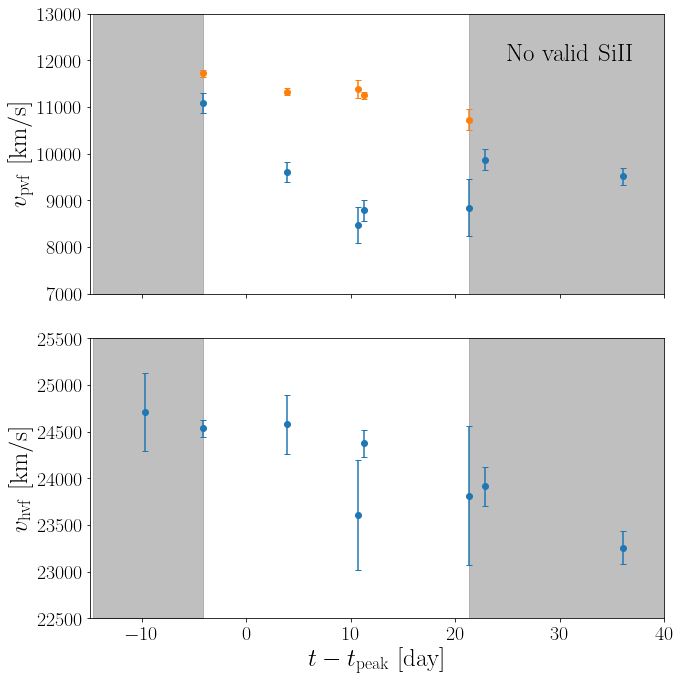

In [53]:
f, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

ylim1 = [7000, 13000]
ylim2 = [22500, 25500]

ax[0].errorbar(date_list,
               -CaII_vel_pvf,
               yerr=CaII_vel_pvf_sig,
               fmt='o',
               capsize=3)
ax[0].errorbar(date_list, -SiII_vel, yerr=SiII_vel_sig, fmt='o', capsize=3)

ax[1].errorbar(date_list,
               -CaII_vel_hvf,
               yerr=CaII_vel_hvf_sig,
               fmt='o',
               capsize=3)
for a, ylim in zip(ax, [ylim1, ylim2]):
    a.fill_betweenx(ylim, [date_list[5], date_list[5]],
                    [date_list[-1], date_list[-1]],
                    color='grey',
                    alpha=0.5)
    a.fill_betweenx(ylim, [date_list[0] - 5, date_list[0] - 5],
                    [date_list[1], date_list[1]],
                    color='grey',
                    alpha=0.5)
ax[0].set_ylabel(r'$v_\mathrm{pvf}\ [\mathrm{km/s}]$')
ax[1].set_ylabel(r'$v_\mathrm{hvf}\ [\mathrm{km/s}]$')
ax[1].set_xlabel(r'$t-t_\mathrm{peak}\ [\mathrm{day}]$')
ax[0].set_ylim(ylim1)
ax[1].set_ylim(ylim2)
ax[1].set_xlim(-15, 40)
ax[0].text(25, 12000, r'$\mathrm{No\ valid\ SiII}$')
plt.tight_layout()